How about looking at the answers to questions specifically about Data Availability statements?

In [1]:
import pandas as pd

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.attrs import ORTH, LEMMA

import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns

import inflect

import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [2]:
df = pd.read_csv("statements.csv", sep="|")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314599 entries, 0 to 1314598
Data columns (total 5 columns):
SITE_NAME           1314598 non-null object
DOCUMENTID          1314599 non-null int64
CUSTOMQUESTIONID    1314599 non-null int64
QUESTIONTEXT        1312766 non-null object
ANSWER_TEXT         1048552 non-null object
dtypes: int64(2), object(3)
memory usage: 50.1+ MB


In [18]:
data_statements = df.copy().dropna(subset=['QUESTIONTEXT', 'ANSWER_TEXT'])
data_statements.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046719 entries, 1 to 1314596
Data columns (total 5 columns):
SITE_NAME           1046718 non-null object
DOCUMENTID          1046719 non-null int64
CUSTOMQUESTIONID    1046719 non-null int64
QUESTIONTEXT        1046719 non-null object
ANSWER_TEXT         1046719 non-null object
dtypes: int64(2), object(3)
memory usage: 47.9+ MB


In [19]:
data_statements = data_statements[data_statements["QUESTIONTEXT"].str.contains("Data Availability")]
data_statements.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34491 entries, 182 to 1314595
Data columns (total 5 columns):
SITE_NAME           34491 non-null object
DOCUMENTID          34491 non-null int64
CUSTOMQUESTIONID    34491 non-null int64
QUESTIONTEXT        34491 non-null object
ANSWER_TEXT         34491 non-null object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [20]:
data_statements["QUESTIONTEXT"].nunique()

10

In [21]:
data_statements["QUESTIONTEXT"].value_counts()

Please cut and paste your Data Availability Statement here (in case your article type is exempt, please enter â€œn/aâ€):                                                                                                                                                                                                           29521
Please cut and paste your Data Availability Statement below. This statement will appear in your published article.                                                                                                                                                                                                                   1286
Please cut and paste your <i>Data Availability Statement</i> here (for Mini Reviews, which are exempt, enter "not applicable")                                                                                                                                                                                                       1109
Please cop

And then same as before to analyze the answers.

In [22]:
nlp = spacy.load('en')

In [23]:
# Add custom stop words to Spacy's list

customize_stop_words = [
    'wiley', 'br', 'href', 'url', 'et', 'al'
]
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [24]:
# Define a special case to not change "data" to "datum"

case = [{ORTH: "data", LEMMA: "data"}]

nlp.tokenizer.add_special_case("data", case)

In [25]:
def spacy_tokenizer(sentence):

    doc = nlp(sentence) 

    mytokens = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ", "PROPN"] and not token.is_stop and not token.like_url]

    prepared_text = " ".join(mytokens)

    return prepared_text

In [26]:
%time data_statements["proc_answers"] = data_statements["ANSWER_TEXT"].apply(spacy_tokenizer)

CPU times: user 5min 55s, sys: 5.43 s, total: 6min 1s
Wall time: 6min 7s


In [27]:
tfidf_vectorizer = CountVectorizer(min_df=5, max_df=0.9)

tfidf = tfidf_vectorizer.fit_transform(data_statements["proc_answers"])

In [28]:
n_topics = 20

lda = LatentDirichletAllocation(n_components=n_topics, random_state=7)

%time topics_model = lda.fit(tfidf)

CPU times: user 1min 14s, sys: 499 ms, total: 1min 15s
Wall time: 1min 17s


In [29]:
# show the top x words in each topic
n_top_words = 30
feature_names = tfidf_vectorizer.get_feature_names()


def get_top_words_topic(topic_idx):
    topic = topics_model.components_[topic_idx]

    print([feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]])


for topic_idx, topic in enumerate(topics_model.components_):
    print("Topic #%d:" % topic_idx)
    get_top_words_topic(topic_idx)
    print("")

Topic #0:
['data', 'available', 'study', 'access', 'analysis', 'open', 'world', 'science', 'use', 'bank', 'agreement', 'database', 'clinical', 'development', 'framework', 'individual', 'researcher', 'trial', 'participant', 'package', 'investigator', 'time', 'statistical', 'international', 'raw', 'dataset', 'service', 'protocol', 'project', 'level']

Topic #1:
['data', 'source', 'available', 'website', 'appendix', 'time', 'text', 'section', 'dataset', 'site', 'table', 'main', 'index', 'image', 'online', 'tables', 'bank', 'year', 'web', 'variable', 'link', 'federal', 'stock', 'value', 'period', 'materials', 'excel', 'rate', 'reserve', 'complete']

Topic #2:
['data', 'manuscript', 'available', 'publication', 'dryad', 'acceptance', 'raw', 'repository', 'present', 'study', 'digital', 'date', 'submission', 'university', 'author', 'conclusion', 'editor', 'analysis', 'dr', 'paper', 'additional', 'process', 'researcher', 'unpublished', 'qualified', 'library', 'final', 'time', 'accessibility', '

In [52]:
# optionally name your topics
dict_topic_name = {i: "topic_" + str(i+1) for i in range(n_topics)}

custom_names = {
    0: "topic_1",
    1: "topic_2",
    
}

dict_topic_name.update(custom_names)

print(dict_topic_name)

{0: 'topic_1', 1: 'topic_2', 2: 'topic_3', 3: 'topic_4', 4: 'topic_5', 5: 'topic_6', 6: 'topic_7', 7: 'topic_8', 8: 'topic_9', 9: 'topic_10', 10: 'topic_11', 11: 'topic_12', 12: 'topic_13', 13: 'topic_14', 14: 'topic_15', 15: 'topic_16', 16: 'topic_17', 17: 'topic_18', 18: 'topic_19', 19: 'topic_20'}


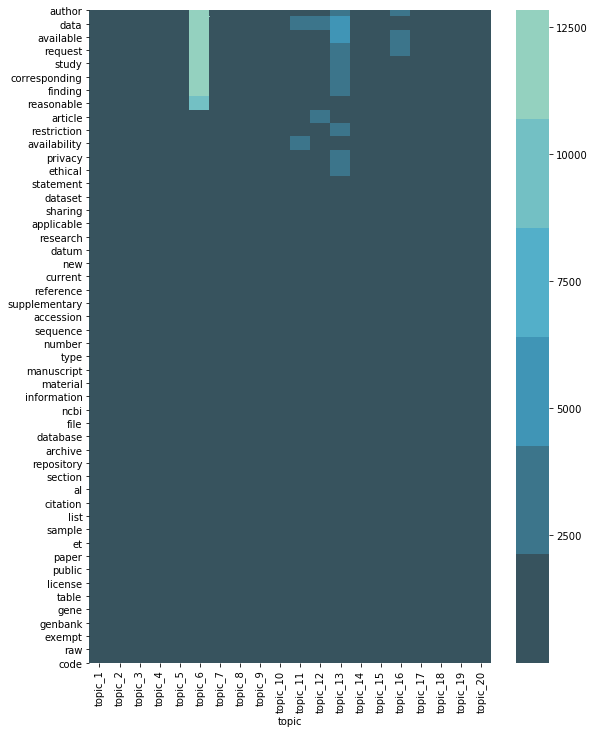

In [53]:
# show which words are most important in the topics
word_model = pd.DataFrame(topics_model.components_.T)
word_model.index = feature_names
word_model.columns.name = "topic"
word_model["norm"] = (word_model).apply(lambda x: x.abs().max(), axis=1)
word_model = word_model.sort_values(
    by="norm", ascending=0
)  # sort the matrix by the norm of row vector
word_model.rename(columns=dict_topic_name, inplace=True)  # naming topic

del word_model["norm"]

plt.figure(figsize=(9, 12))
cmap = sns.color_palette("GnBu_d")
sns.heatmap(word_model[:50], cmap=cmap)

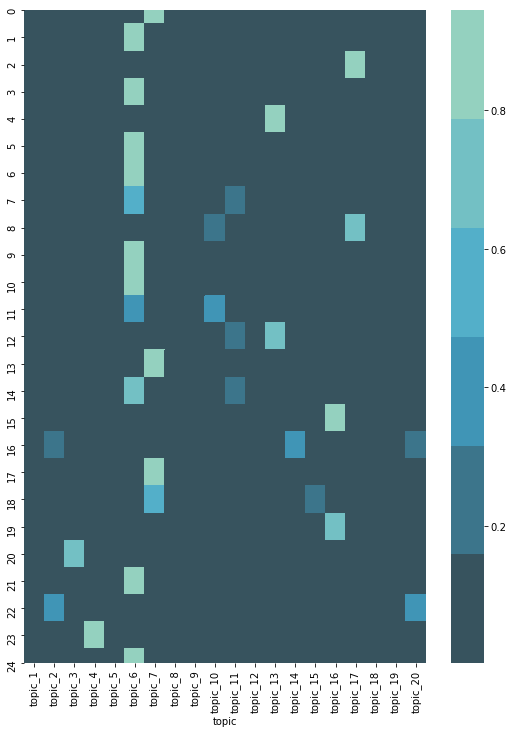

In [54]:
# retrieve the document-topic matrix - show which topic is dominant in each "document"
document_model = pd.DataFrame(topics_model.transform(tfidf))
document_model.columns.name = 'topic'
document_model.rename(columns = dict_topic_name, inplace = True) #naming topics
plt.figure(figsize=(9,12))
sns.heatmap(document_model.sort_index()[:25], cmap=cmap) #we limit here to the first 25 texts

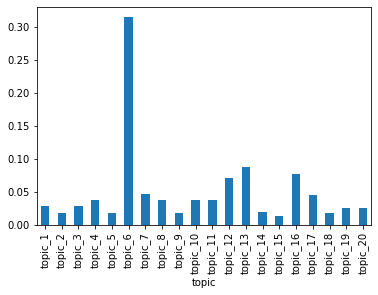

In [55]:
topics_proportion = document_model.sum()/document_model.sum().sum()
topics_proportion.plot(kind = "bar")

In [56]:
def top_documents_topics(topic_name, n_doc = 3, excerpt = True):
    '''This returns the n_doc documents most representative of topic_name'''
    
    p = inflect.engine()
    
    document_index = list(document_model[topic_name].sort_values(ascending = False).index)[:n_doc]
    
    for order, i in enumerate(document_index):
        
        print(f"Text for the {p.ordinal(order + 1)} most representative document ({i}) for topic {topic_name}:\n")
        print(data_statements.iloc[i,4])
        print("\n******\n")

In [63]:
top_documents_topics("topic_13", n_doc=5)

Text for the 1st most representative document (22960) for topic topic_13:

Selected data that support the findings of this study are available online, while other data are available on request from the corresponding author. The latter data are not publicly available due to privacy or ethical restrictions.

******

Text for the 2nd most representative document (3799) for topic topic_13:

The data that support the findings of this study are available on request from the corresponding author with permission from Cobb-Vantress. The data are not publicly available due to privacy or ethical restrictions.

******

Text for the 3rd most representative document (23870) for topic topic_13:

The data that support the findings of this study are available on request from the corresponding author, Maria Luisa Lorusso. The data are not publicly available due to privacy or ethical restrictions.

******

Text for the 4th most representative document (22409) for topic topic_13:

The data that support th

In [61]:
topic_vis_data = pyLDAvis.sklearn.prepare(topics_model, tfidf, tfidf_vectorizer, sort_topics=False)
pyLDAvis.display(topic_vis_data)

/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
